# Model 1: Sentiment Analysis
### Importing Libraries

In [28]:
""" A Sentiment analysis pipeline using DistilRoBERTa model"""

# Import necessary libraries
import os
import textwrap
import pandas as pd
import numpy as np
import evaluate
from datasets import Dataset
from transformers import (
    pipeline,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    get_scheduler,
)
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import torch

# Loading the dataset and initializing

In [29]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#final_df = pd.read_csv("final_dataset.csv")
final_df = pd.read_csv("final_dataset_200k.csv")

# Combine title and text columns into a single review column to provide more context
final_df["review"] = final_df["title"].fillna("") + ". " + final_df["text"].fillna("")

# tqdm initialization for pandas
tqdm.pandas()

# Constants
TRAIN_MODEL = False
SAVE_MODEL = False

MODEL_NAME = "distilbert/distilroberta-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Analyzing then length of the reviews

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


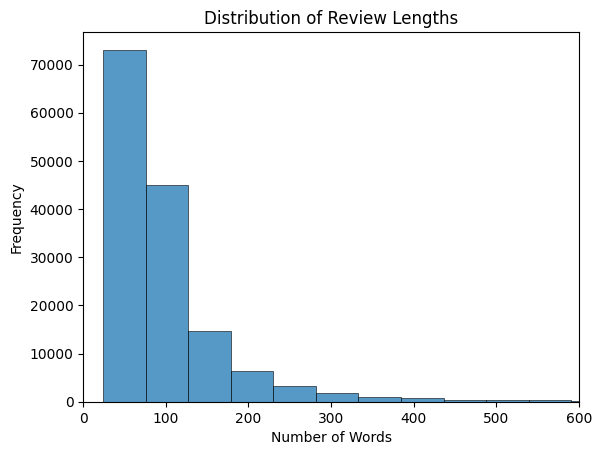

Percentage of reviews longer than 512 words: 0.80%
Minimum review length: 24
Median review length: 76
Mean review length: 101
Maximum review length: 4145


In [30]:
# Calculate review lengths based on word count (split by whitespace)
review_lengths = final_df["review"].apply(lambda x: len(str(x).split()))

# Plotting the distribution of review lengths
sns.histplot(review_lengths, bins=80)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.xlim(0, 600)  # Adjust this based on your data
plt.show()

# Calculate percentage of reviews longer than 512 words
percentage_over_512 = ((review_lengths > 512).sum() / len(review_lengths)) * 100
print(f"Percentage of reviews longer than 512 words: {percentage_over_512:.2f}%")

# Print summary statistics
print(f"Minimum review length: {review_lengths.min()}")
print(f"Median review length: {int(review_lengths.median())}")
print(f"Mean review length: {int(review_lengths.mean())}")
print(f"Maximum review length: {review_lengths.max()}")

In [31]:
final_df.shape

(147741, 8)

In [17]:
final_df = final_df[final_df['review'].apply(lambda x: len(x.split())) <= 512]

# Optional: print the number of rows dropped
rows_dropped = len(review_lengths) - len(final_df)
print(f"Number of rows dropped: {rows_dropped}")
final_df.shape

Number of rows dropped: 157109


(0, 8)

In [6]:
# Initialize tokenizer with max length for consistency
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=512)

# Implement sliding window tokenization for reviews longer than 512 tokens
def sliding_window_tokenizer(review_text, max_length=400, stride=100):
    """
    This function tokenizes a review text using a sliding window approach, where
    the text is divided into overlapping chunks of a specified maximum length.
    The resulting tokens are returned along with any overflowing tokens that
    do not fit within the maximum length.

    Args:
        review_text (str): The text of the review to be tokenized.
        max_length (int, optional): The maximum length of each tokenized chunk.
            Defaults to 400.
        stride (int, optional): The stride of the sliding window, i.e. the number
            of tokens to move the window forward by. Defaults to 100.

    Returns:
        dict: A dictionary containing the tokenized chunks and any overflowing tokens.
    """
    return tokenizer(
        review_text,
        truncation=True,
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
    )


# Apply sliding window tokenization to reviews
sliding_tokenized_reviews = []
for review in tqdm(final_df["review"], desc="Tokenizing Reviews"):
    tokenized_chunks = sliding_window_tokenizer(review)
    sliding_tokenized_reviews.extend(tokenized_chunks["input_ids"])

Tokenizing Reviews: 100%|██████████| 157109/157109 [00:57<00:00, 2719.09it/s]


# Generating the labels for Sentiment

In [9]:
# Load the DistilRoBERTa model for sentiment analysis
classifier = pipeline(
    "sentiment-analysis",
    model="./sentiment-fine-tuned-distilroberta",
    tokenizer=tokenizer,
    device=0,
)


# Apply DistilRoBERTa sentiment analysis on the 'review' column with progress tracking
def transformer_sentiment(review_text):
    """
    Classify the sentiment of a review text using a transformer-based classifier.

    This function takes a review text as input, passes it through a transformer-based
    classifier, and returns the predicted sentiment label and score.

    Args:
        review_text (str): The text of the review to be classified.

    Returns:
        tuple: A tuple containing the predicted sentiment label (str) and score (float).
    """
    # Use consistent max_length and padding to prevent size mismatches
    result = classifier(review_text, truncation=True, padding=True, max_length=512)[0]
    return result["label"], result["score"]


# Apply the new sentiment function with progress tracking
final_df[["sentiment", "sentiment_score"]] = final_df["review"].progress_apply(
    lambda x: pd.Series(transformer_sentiment(x))
)

  0%|          | 2/157109 [00:01<27:06:32,  1.61it/s]/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 157109/157109 [11:37<00:00, 225.35it/s]


### Visualization of label distribution and ratings

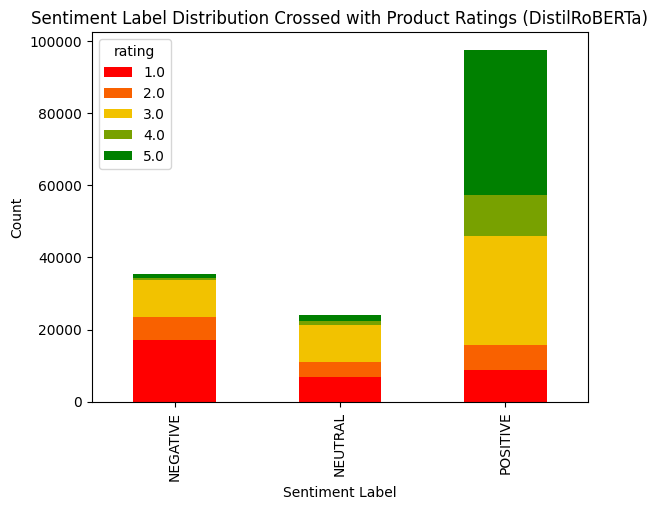

In [10]:
# Cross-tabulate sentiment with product ratings to visualize the alignment
cross_tab = pd.crosstab(final_df["sentiment"], final_df["rating"])
custom_cmap = LinearSegmentedColormap.from_list(
    "red_to_green", ["red", "#f3c200", "green"]
)
cross_tab.plot(kind="bar", stacked=True, colormap=custom_cmap)
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Sentiment Label Distribution Crossed with Product Ratings (DistilRoBERTa)")
plt.show()

### Saving Dataframe with the labels

In [11]:
# Reorder columns and drop null rows
final_df = final_df[
    [
        "title",
        "text",
        "review",
        "rating",
        "sentiment",
        "sentiment_score",
        "id",
        "name",
        "categories",
        "review_length",
    ]
]
final_df.dropna(inplace=True, axis=0)  # Double check for null values

# Save the processed dataset
final_df.to_pickle("final_dataset_sent.pkl")

# final_df = pd.read_pickle('final_dataset_sent.pkl')

# Model configuration before training
### Train, Test, Val Split

In [13]:
# Map sentiment to labels
label_mapping = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}
final_df["labels"] = final_df["sentiment"].map(label_mapping)

# Convert to Dataset
dataset = Dataset.from_pandas(final_df[["review", "labels"]])

# Split into train, validation, and test sets with stratification
df = final_df[["review", "labels"]]
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["labels"], random_state=42
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, stratify=train_val_df["labels"], random_state=42
)

# Convert splits to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

### Tokenization

In [14]:
# Preprocess function
def preprocess_function(examples):
    """
    Tokenize a batch of review texts.

    Tokenizes the review texts in the input examples and returns the resulting
    tokenized outputs.

    Args:
        examples (dict): A dictionary containing a batch of review texts, where each
            text is stored in the "review" key.

    Returns:
        dict: A dictionary containing the tokenized outputs.
    """
    return tokenizer(examples["review"], truncation=True, max_length=256)


# Tokenize datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True).remove_columns(
    ["review"]
)
tokenized_val = val_dataset.map(preprocess_function, batched=True).remove_columns(
    ["review"]
)
tokenized_test = test_dataset.map(preprocess_function, batched=True).remove_columns(
    ["review"]
)


# Define a dict mapping label IDs to their corresponding label names and viceversa
id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
label2id = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

# Model setup
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
)

# Using dynamic padding since our sequences have variable lengths and it's more memory efficient
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

Map:   0%|          | 0/94265 [00:00<?, ? examples/s]

Map:   0%|          | 0/31422 [00:00<?, ? examples/s]

Map:   0%|          | 0/31422 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Methods for Training adjustments

In [15]:
# Load the necessary metrics
# metrics = evaluate.load("accuracy","f1_score","precision","recall")
metrics = evaluate.load("accuracy")


# Compute metrics
def compute_metrics(eval_preds):
    """
    Computes accuracy for the model's predictions.

    Args:
        eval_preds (tuple): A tuple containing logits and labels from the model evaluation.

    Returns:
        dict: A dictionary containing the computed accuracy metric.
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(predictions=predictions, references=labels)


# Custom Trainer class to override the loss computation
class CustomTrainer(Trainer):
    """
    Custom Trainer class to override the loss computation and include class weights.

    Args:
        weights (array): Array of class weights computed based on the class distribution.
        *args: Additional arguments for the Trainer class.
        **kwargs: Additional keyword arguments for the Trainer class.
    """
    def __init__(self, weights, *args, **kwargs):
        """
        Initializes the CustomTrainer with class weights and the model setup.

        Args:
            weights (array): Array of class weights for handling class imbalance.
            *args: Additional arguments passed to the parent Trainer class.
            **kwargs: Additional keyword arguments passed to the parent Trainer class.
        """
        super().__init__(*args, **kwargs)
        
        # Compute class weights using sklearn's compute_class_weight
        weights = compute_class_weight(
            class_weight="balanced", classes=[0, 1, 2], y=final_df["labels"].values
        )
        
        # Convert weights to a tensor
        self.weights_tensor = torch.tensor(
            weights, dtype=torch.float32, device="cuda"
        )
        
    def compute_loss(self, tf_model, inputs, return_outputs=False):
        """
        Computes the loss using weighted cross-entropy to handle class imbalance.

        Args:
            tf_model (nn.Module): The model used for training.
            inputs (dict): A dictionary containing the input data and labels.
            return_outputs (bool, optional): If True, returns both loss and outputs. Defaults to False.

        Returns:
            torch.Tensor or tuple: The loss, and optionally the outputs if `return_outputs` is True.
        """
        tf_labels = inputs.get("labels")
        outputs = tf_model(**inputs)
        loss = torch.nn.functional.cross_entropy(
            outputs.logits, tf_labels, weight=self.weights_tensor
        )
        return (loss, outputs) if return_outputs else loss

# Training
### Training Arguments and hyperparameters using Trainer API

In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=2,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    report_to=["none"],
    logging_first_step=True,
    dataloader_num_workers=8,
    fp16=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True,
    disable_tqdm=False,
)

# Initialize learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=training_args.num_train_epochs * len(tokenized_train),
)

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(optimizer, lr_scheduler),
)

if TRAIN_MODEL:
    trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenize

Epoch,Training Loss,Validation Loss,Accuracy
0,0.514500,0.376580,0.852015
2,0.243000,0.228415,0.924766
4,0.181600,0.205759,0.930876
6,0.132400,0.248490,0.924830


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenize

TrainOutput(global_step=2579, training_loss=0.265753840790002, metrics={'train_runtime': 1446.796, 'train_samples_per_second': 1303.086, 'train_steps_per_second': 5.087, 'total_flos': 4.370541708024576e+16, 'train_loss': 0.265753840790002, 'epoch': 7.0})

### Saving the model

In [18]:
if SAVE_MODEL:
    trainer.save_model("./sentiment-fine-tuned-distilroberta")

In [19]:
local_model = AutoModelForSequenceClassification.from_pretrained(
    "./sentiment-fine-tuned-distilroberta"
)

# Evaulation and Inference

In [ ]:
with open("eval_results.txt", "w", encoding="utf-8") as f:
    print(trainer.evaluate())

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenize

              precision    recall  f1-score   support

    NEGATIVE       0.90      0.92      0.91      7079
     NEUTRAL       0.79      0.88      0.83      4818
    POSITIVE       0.98      0.94      0.96     19525

    accuracy                           0.93     31422
   macro avg       0.89      0.91      0.90     31422
weighted avg       0.93      0.93      0.93     31422



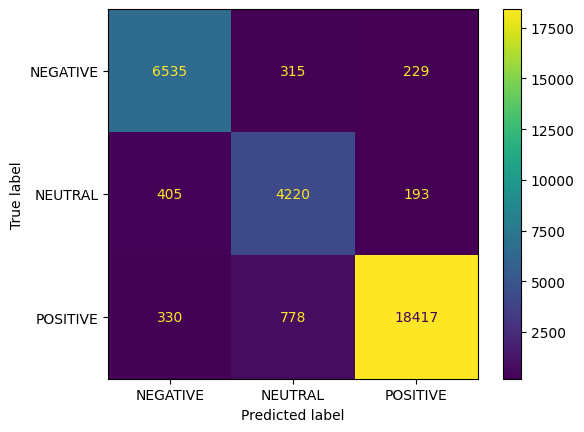

In [20]:
# Load classifier for predictions
classifier = pipeline(
    "sentiment-analysis", model="./sentiment-fine-tuned-distilroberta"
)

# Evaluate the model on the test set and calculate additional metrics
predictions, labels, metrics = trainer.predict(tokenized_test)
logits = predictions  # The predictions variable contains the logits
predicted_labels = np.argmax(logits, axis=-1)

# Calculate classification report
print(
    classification_report(
        labels, predicted_labels, target_names=["NEGATIVE", "NEUTRAL", "POSITIVE"]
    )
)

# Confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["NEGATIVE", "NEUTRAL", "POSITIVE"]
)
disp.plot(cmap="viridis")
plt.show()

with open("Sentiment_Predictions.txt", "w", encoding="utf-8") as f:
    # Print and classify a few sampled texts
    sampled_texts = test_dataset.shuffle().select(range(5))["review"]
    for text in sampled_texts:
        print(textwrap.fill(f"TEXT: {text}", width=80), file=f)
        print(f"CLASSIFICATION: {classifier(text)}\n", file=f)
        print("-" * 80, file=f)